In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import os
from scipy.signal import argrelextrema


In [15]:
data_dir = 'ohlc_data'
symbols = ['EURUSD', 'AUDUSD', 'GBPUSD', 'USDCAD', 'USDCHF', 'USDJPY']
dataset = []

for i in symbols:
    data_path = os.path.join(os.getcwd(), data_dir, i, 'H1_'+i+'_2015.csv')
    print(data_path)
    
    data = pd.read_csv(data_path, index_col=0)
    
    # Convert Unix timestamps to datetime format
    data['Time'] = pd.to_datetime(data['time'], unit='s')
    
    if 'volume' not in data.columns:
        data.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'tick_volume':'Volume'}, inplace=True)
    else:
        data.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace=True)

    data['Date'] = data['Time']
    data.drop(columns=['time', 'spread', 'real_volume'], inplace=True)
    dataset.append(data)

D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\H1_EURUSD_2015.csv
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\H1_AUDUSD_2015.csv
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\H1_GBPUSD_2015.csv
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\H1_USDCAD_2015.csv
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\H1_USDCHF_2015.csv
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\H1_USDJPY_2015.csv


In [10]:
dataset[1]

,time,Open,High,Low,Close,Volume,Time,Date
0,1420048800,0.81812,0.81913,0.81737,0.81769,2503,2014-12-31 18:00:00,2014-12-31 18:00:00
1,1420185600,0.81356,0.81445,0.81354,0.81414,1193,2015-01-02 08:00:00,2015-01-02 08:00:00
2,1420189200,0.81414,0.81414,0.81258,0.81381,2508,2015-01-02 09:00:00,2015-01-02 09:00:00
3,1420192800,0.81382,0.81448,0.81364,0.81426,2845,2015-01-02 10:00:00,2015-01-02 10:00:00
4,1420196400,0.81427,0.81451,0.81352,0.81413,2351,2015-01-02 11:00:00,2015-01-02 11:00:00
...,...,...,...,...,...,...,...,...
61933,1734688800,0.62449,0.62481,0.62351,0.62370,3645,2024-12-20 10:00:00,2024-12-20 10:00:00
61934,1734692400,0.62371,0.62379,0.62285,0.62318,3100,2024-12-20 11:00:00,2024-12-20 11:00:00
61935,1734696000,0.62318,0.62350,0.62264,0.62290,2254,2024-12-20 12:00:00,2024-12-20 12:00:00
61936,1734699600,0.62290,0.62290,0.62236,0.62252,2181,2024-12-20 13:00:00,2024-12-20 13:00:00


In [16]:
def create_signal(df, symbol, data_dir = 'ohlc_data'):
    # Calculate percentage change
    df['Percentage_Change'] = df['Close'].pct_change() * 100  # Calculate percentage change in Close prices
    df.dropna(inplace=True)  # Drop NaN values caused by percentage change calculation

    # Label clusters based on percentage change thresholds
    def assign_cluster_label(percentage_change, threshold=0.35):
        if percentage_change > threshold:  # Positive change
            return 'Buy'
        elif percentage_change < -threshold:  # Negative change
            return 'Sell'
        else:  # Sideways movement within threshold
            return 'Hold'

    # Assign cluster labels based on logic
    df['Cluster_Label'] = df['Percentage_Change'].apply(assign_cluster_label)

    # Generate buy and sell signals
    df['Signal'] = None
    df.loc[df['Cluster_Label'] == 'Buy', 'Signal'] = 'Buy'
    df.loc[df['Cluster_Label'] == 'Sell', 'Signal'] = 'Sell'

    # Identify local maxima and minima
    local_maxima_indices = argrelextrema(df['Close'].values, np.greater, order=800)[0]
    local_minima_indices = argrelextrema(df['Close'].values, np.less, order=800)[0]

    # Add local maxima as additional "Sell" signals
    df.loc[df.index[local_maxima_indices], 'Signal'] = 'Sell'

    # Add local minima as additional "Buy" signals
    df.loc[df.index[local_minima_indices], 'Signal'] = 'Buy'

    # Visualize signals
    plt.figure(figsize=(14, 7))

    # Plot Close Prices
    plt.plot(df['Date'], df['Close'], c='gray', alpha=0.7, label='Close Price', linewidth=1)

    # Plot Buy Signals (including local minima)
    buy_signals = df[df['Signal'] == 'Buy']
    plt.scatter(buy_signals['Date'], buy_signals['Close'], 
                c='green', label='Buy Signal (Including Local Minima)', marker='^', s=20)

    # Plot Sell Signals (including local maxima)
    sell_signals = df[df['Signal'] == 'Sell']
    plt.scatter(sell_signals['Date'], sell_signals['Close'], 
                c='red', label='Sell Signal (Including Local Maxima)', marker='v', s=20)

    # Chart Customization
    plt.title('Buy and Sell Signals on Close Prices (Including Extrema)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Signal Type')
    plt.grid(alpha=0.5)
    plt.show()

    # Print signal summary
    print("Signal Counts:")
    print(df['Signal'].value_counts())
    
    df.drop(columns=['Cluster_Label'], inplace=True)
    # Replace None with 'Hold' in the Signal column
    df['Signal'] = df['Signal'].fillna('Hold')
    
 
    df.to_csv(os.path.join(os.getcwd(), data_dir, symbol,'Signal_'+symbol+'.csv'))
    
    

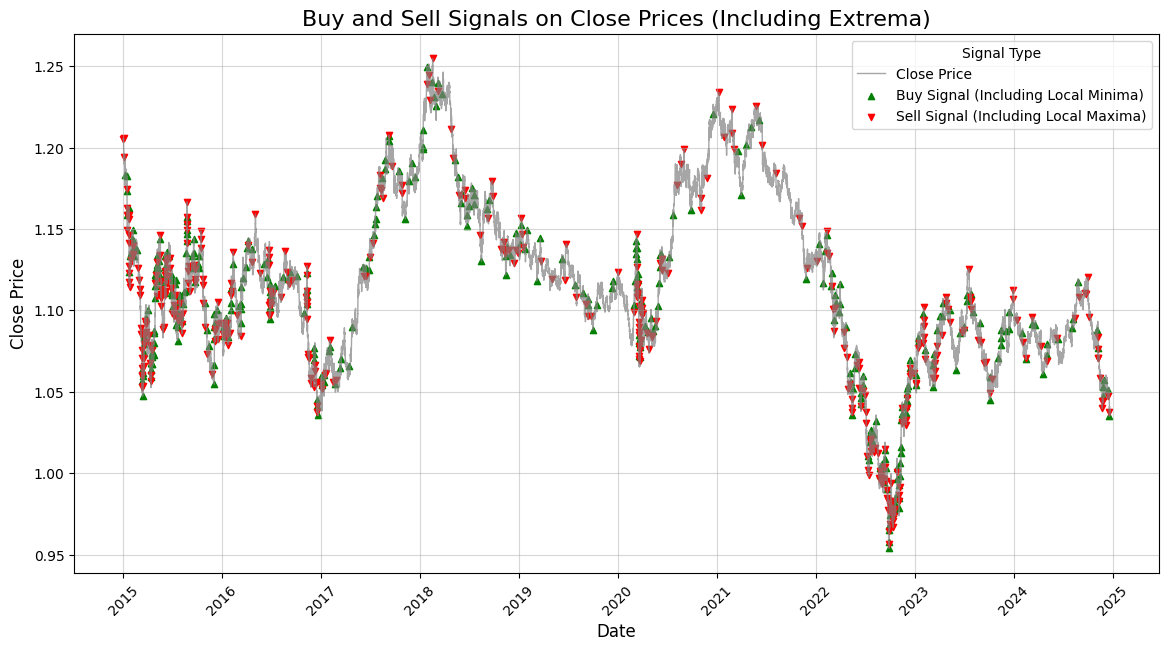

Signal Counts:
Signal
Buy     411
Sell    404
Name: count, dtype: int64


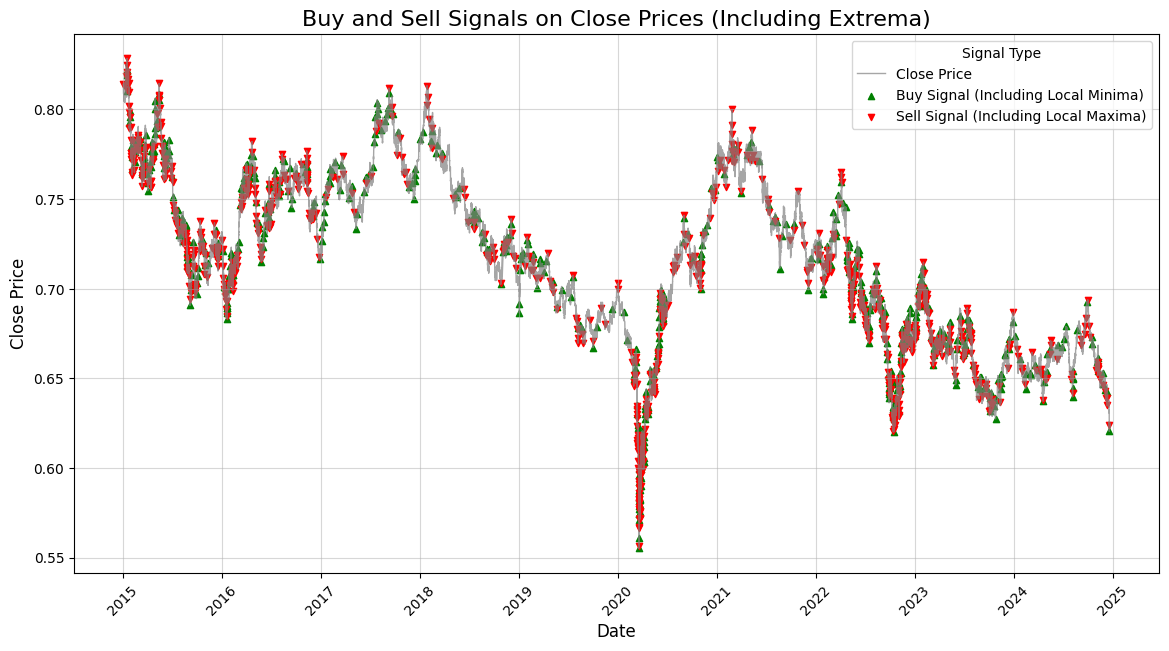

Signal Counts:
Signal
Sell    797
Buy     744
Name: count, dtype: int64


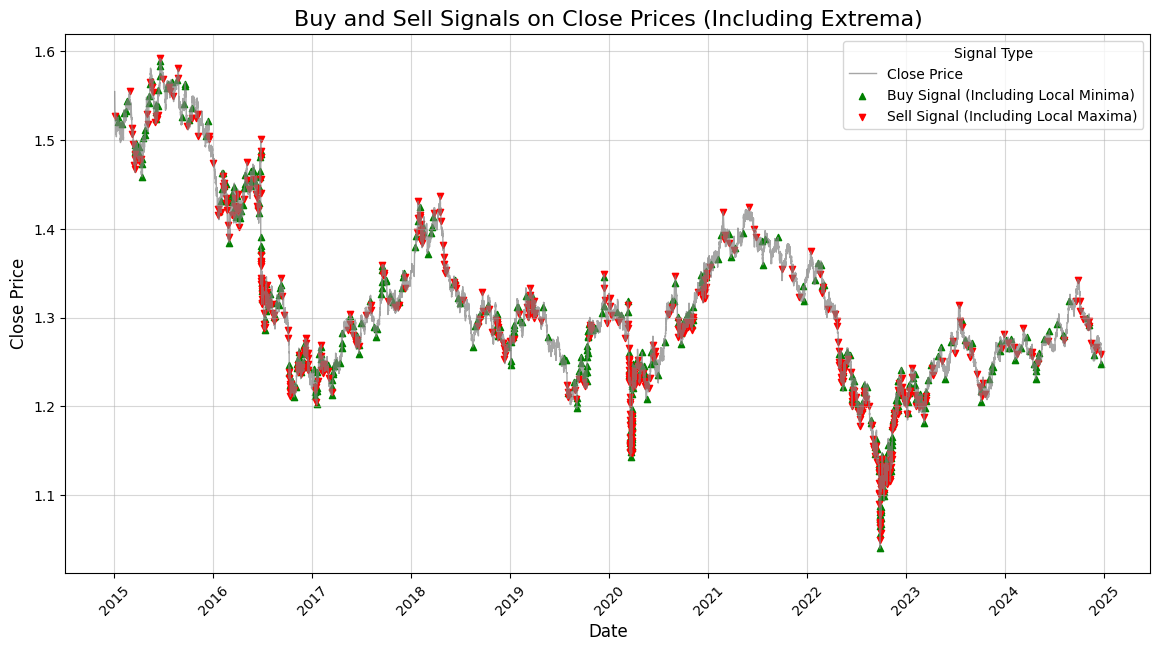

Signal Counts:
Signal
Buy     566
Sell    545
Name: count, dtype: int64


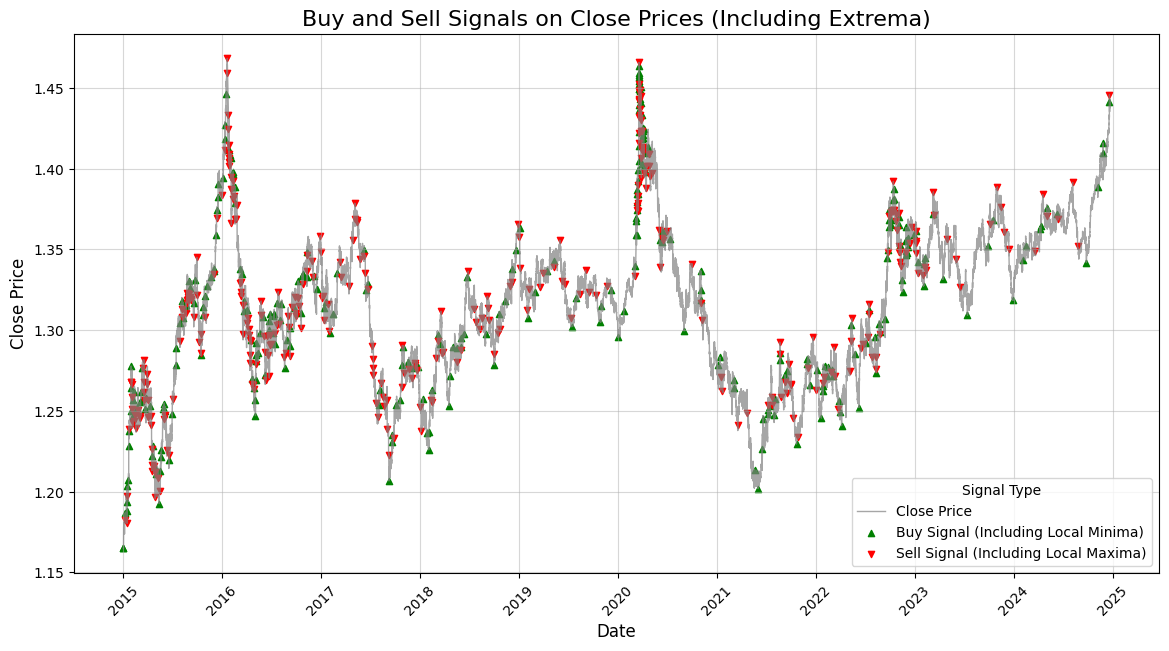

Signal Counts:
Signal
Sell    344
Buy     311
Name: count, dtype: int64


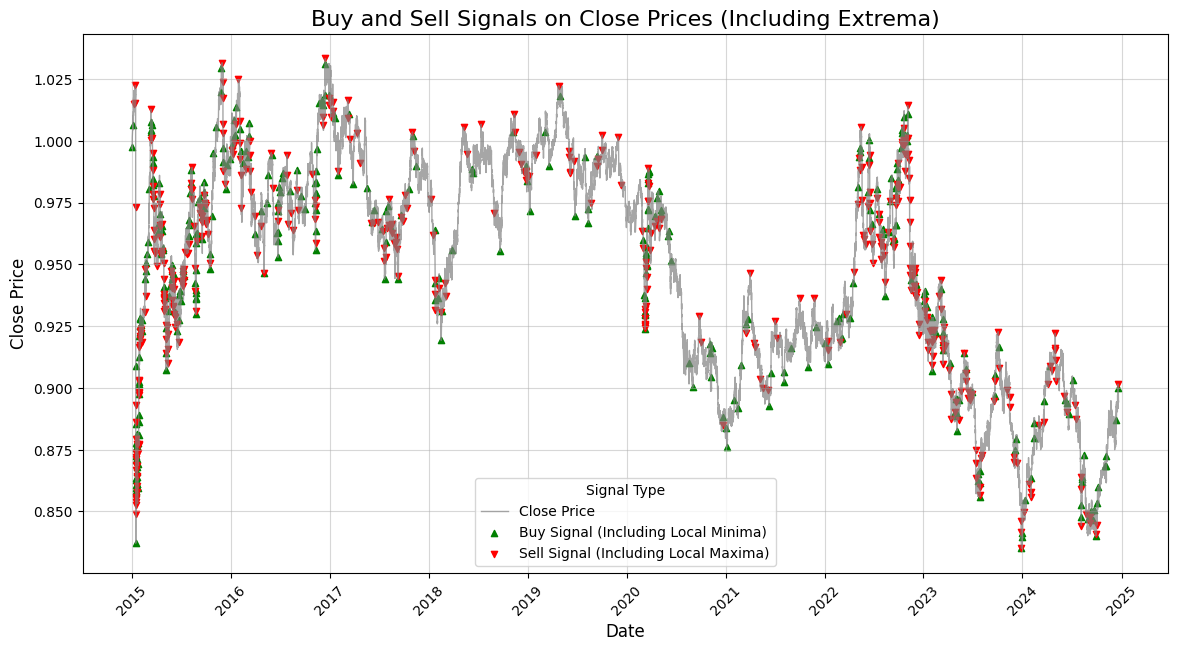

Signal Counts:
Signal
Sell    436
Buy     389
Name: count, dtype: int64


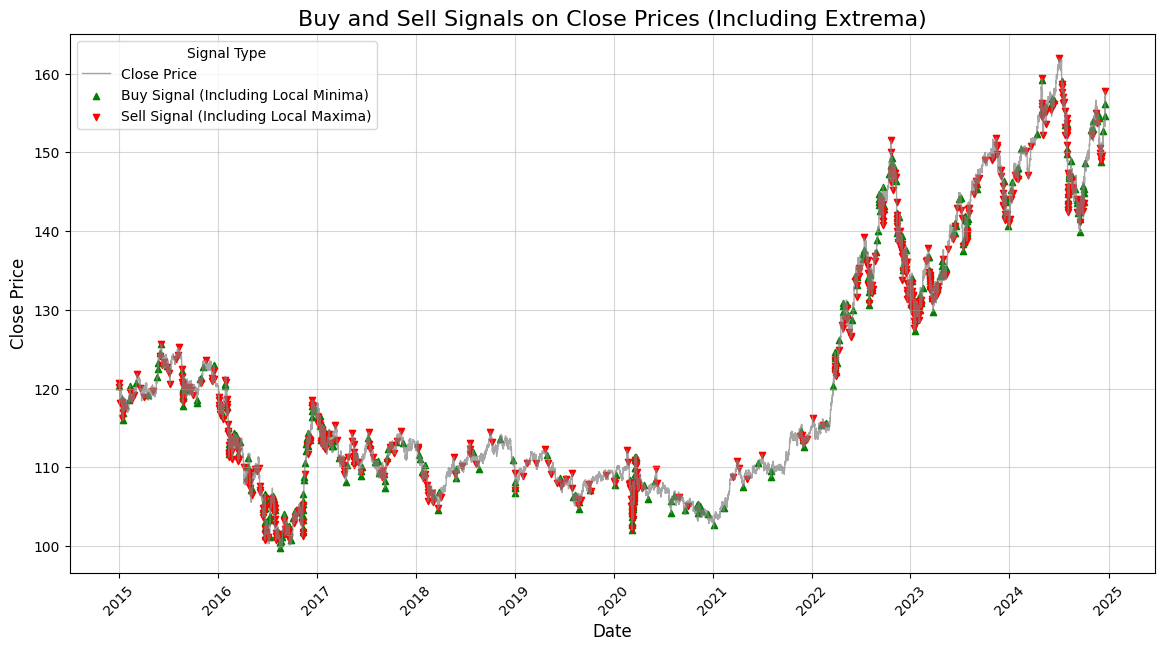

Signal Counts:
Signal
Sell    535
Buy     461
Name: count, dtype: int64


In [18]:
index = 0
for i in dataset:    
    create_signal(i, symbols[index])
    index+=1
#     break